# Linear Regression with Stochastic Gradient Descent

This notebook demonstrates how to perform linear regression using stochastic gradient descent on synthetic data. We'll walk through each part of the code step-by-step to understand the concepts involved.

#### **Import Required Libraries**

- **NumPy** is used for numerical operations and handling arrays.
- **Matplotlib** is for plotting graphs to visualize results.
- **TQDM** provides a progress bar for loops.
- **Scikit-learn** is used for calculating the R² score, which evaluates our model.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

pbar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

## 1. Helper Function for all SGD

### Generate Synthetic Data

We create a function to generate synthetic data that follows a linear relationship.
- **Parameters**:
  - `n`: Number of data points.
  - `bias`: Intercept of the line.
  - `weight`: Slope of the line.
- **Output**: An array containing features and labels.

In [2]:
def synthetic_data(n=100, bias=5, weight=2):
    np.random.seed(42)
    torch.manual_seed(42) 

    # Generate synthetic data (linear relationship with some noise)
    bias = 5
    weight = 2
    noise = np.random.randn(n)

    features = np.random.rand(n, 1) * 10
    labels = bias + weight * features.flatten() + noise  # Linear relation with noise

    data = np.hstack((features, labels.reshape(-1, 1)))
    return data

### Visualizing Results

This function will create plots for:
- Loss over epochs
- Values of model parameters (weights)


In [3]:
def plot_results(history, cost_history, lr, fontsize=10, markersize=8):

    history = np.array(history)

    # Create subplots: 3 rows, 1 column
    fig, axs = plt.subplots(history.shape[1] + 1, 1, figsize=(12, 15))  # Adjusted number of rows

    # Plot the loss over epochs
    axs[0].plot(range(len(cost_history)), cost_history, '*-b', markersize=markersize, label='Loss per Epoch')
    axs[0].set_title(f'Loss per Epoch for lr={lr}', fontsize=16, fontweight='bold')
    axs[0].set_xlabel('Iteration', fontsize=fontsize)
    axs[0].set_ylabel('Loss', fontsize=fontsize)
    axs[0].legend()
    axs[0].grid(True)

    # Plot the values of each theta over iterations
    for i in range(history.shape[1]):
        axs[i + 1].plot(history[:, i], '-m.', markersize=markersize, label=f'Theta {i}')
        axs[i + 1].set_title(f'Theta {i} Values over Iterations for lr={lr}', fontsize=fontsize + 4, fontweight='bold')
        axs[i + 1].set_ylabel(f'Theta {i} Value', fontsize=fontsize)
        axs[i + 1].set_xlabel('Iteration', fontsize=fontsize)
        axs[i + 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


### Evaluate the Model

We define a function to evaluate the model's performance using the R² score:


In [4]:
from sklearn.metrics import r2_score

def evaluate_model(X, y, theta):
    predictions = X @ theta
    return r2_score(y, predictions)

### (optional) Use Decorators to Display Pretty Report after Training

In [5]:
def report_decorator(func):
    def report(*args, **kwargs):

        result = func(*args, **kwargs) 
        epoch, weights_history, cost_history, r2 = result
        
        print("="*60)
        print(" "*20, "Final Training Report")
        print("="*60)
        print(f"🟢 Total Epochs Run : {epoch+1}")
        print(f"🟢 Final MSE        : {cost_history[-1]:.3f}")
        print(f"🟢 Final R-square   : {r2:.3f}")
        print(f"🟢 Final Weights    : [{' '.join(f'{float(w):.4f}' for w in weights_history[-1].flatten())}]")
        print("="*60)
        
        return result
    
    return report

### (optional) Use Decorators to Calculate Time Duration of the Training

In [6]:
import time

def time_decorator(func):
    def training(*args, **kwargs):
        start_time = time.time()        # Start time
        result = func(*args, **kwargs)  # Call the function
        end_time = time.time()          # End time
        print(f"Time taken for {func.__name__}: {end_time - start_time:.4f} seconds")
        return result
    return training

## 2. Stocastic Gradient Descent Using Python

The `SGD_python` function implements the Stocastic Gradient Descent (SGD) algorithm using **Python** to optimize the parameters (weights) of a linear regression model.

**Key Changes from BGD to SGD:**

- **Single Example Processing**: Instead of processing the entire dataset, the code processes **one example at a time** in each iteration.
- **Frequent Updates**: The weights are updated after each example, instead of after the entire dataset.
- **Noisy Cost Function**: The cost function is computed for each individual example.
- **Shuffling Data**: The dataset is shuffled at the beginning of each epoch to ensure random selection of training examples.

### Implementing Stocastic Gradient Descent Using Python

In [7]:
@report_decorator
@time_decorator
def SGD_python(X, y, **hyperparams):

    np.random.seed(42)    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    tolerance = hyperparams.get('tolerance', 0.001)
    
    X = np.insert(X, 0, 1, axis=1)
    y = y.reshape(-1, 1)
    m = len(y)                          # Number of training examples
    n = X.shape[1]                      # Number of features
    cost_history = []                   # Store all losses per iteration
    avg_losses = []                     # Store all average losses per epoch
    weights_history = []                # Store all weights per iteration
    patience_count = 0                  # Initialize a counter for early stopping
    best_loss = float('inf')            # Initialize best loss with infinity
    theta = np.zeros((n, 1))            # Initialize theta with zeros
    weights_history.append(theta.copy())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs * m, colour='green', ncols=150, bar_format=pbar_format)
    
    for epoch in range(epochs):

        total_loss = 0                      # Initialize total loss for the epoch
        indices = np.random.permutation(m)  # Shuffle dataset before the epoch
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(m):
            # 1. Predict output using current theta (weights)
            x_i, y_i = X_shuffled[i, :].reshape(1, -1), y_shuffled[i]
            h_x = (x_i @ theta)[0]

            # 2. Calculate Error for the instance
            e = h_x - y_i
            loss = e[0] ** 2
            cost_history.append(loss)
            total_loss += loss  # Accumulate the loss for averaging

            # 3. Calculate gradient and update theta
            gradient = (x_i * e).reshape(-1, 1)
            
            # 4. Update weights
            theta = theta - learning_rate * gradient
            weights_history.append(theta.copy())

        # Average loss for the epoch
        avg_losses.append(total_loss / m)

        # Track the best loss
        if total_loss < best_loss:
            best_loss = total_loss
            patience_count = 0  # Reset patience count if we improve
        else:
            patience_count += 1  # Increment patience count if no improvement
            
        # Early stopping for convergence
        if patience_count >= 5:  # Check if the loss has not decreased for 5 consecutive epochs
            print(f"Loss increased for 5 consecutive epochs. Stopping training at epoch {epoch + 1}.")
            break

        # Compute R
        r2 = evaluate_model(X_shuffled, y_shuffled, theta)
        
        # Print progress
        pbar.set_description(f"Epoch [{epoch + 1}/{epochs}] - Avg Loss: {avg_losses[-1]:.3f} - R2: {r2:.3f} - Weights: {theta.flatten()}")
        pbar.update(1)

    pbar.close()
    return epoch, weights_history, cost_history, r2


### Run the Model

It's essential to understand how different parameters affect the performance of the model. I encourage you to:

1. **Change the Number of Data Points**:
   - Modify the `n` parameter in the `synthetic_data` function and Observe how the amount of training data influences the model's performance and convergence speed.
   - **Example:** Try using `50, 200, or 500` data points.
   - **Note:** This will help you understand how the model's performance scales with the amount of training data.

2. **Adjust the Learning Rate**:
   - Experiment with different **learning rates** in the `Stocastic_gd` function and Observe how the **learning rate** affects convergence.
   - **Example:** Common values to try include `0.01, 0.001, and 0.0001`.
   - **Note:** A learning rate that is too high can cause the model to oscillate before convergence, while a learning rate that is too low can slow down convergence.

3. **Adjust the Epochs Numbers**:
   - Experiment with different numbers of **epochs** in the `Stocastic_gd` function. Observe how the number of **epochs** affects the model's performance and convergence.
   - **Example:** try `100, 500, or 1000` epochs.
   - **Note:** A larger number of epochs may lead to better convergence but may also increase training time.

### Use Small Learning Rate

In [8]:
# Generate 100 synthetic data points
data = synthetic_data(n=50, bias=5, weight=2)
X, y = data[:, :-1], data[:, -1]
print(f"X: {X}\n \n y: {y}")

X: [[1.40924225]
 [8.02196981]
 [0.74550644]
 [9.86886937]
 [7.72244769]
 [1.98715682]
 [0.05522117]
 [8.15461428]
 [7.06857344]
 [7.29007168]
 [7.71270347]
 [0.74044652]
 [3.58465729]
 [1.1586906 ]
 [8.63103426]
 [6.23298127]
 [3.30898025]
 [0.6355835 ]
 [3.10982322]
 [3.25183322]
 [7.29606178]
 [6.37557471]
 [8.87212743]
 [4.72214925]
 [1.19594246]
 [7.13244787]
 [7.60785049]
 [5.61277198]
 [7.7096718 ]
 [4.93795596]
 [5.22732829]
 [4.27541018]
 [0.25419127]
 [1.07891427]
 [0.31429186]
 [6.36410411]
 [3.14355981]
 [5.08570691]
 [9.07566474]
 [2.49292229]
 [4.10382923]
 [7.55551139]
 [2.28798165]
 [0.7697991 ]
 [2.89751453]
 [1.61221287]
 [9.29697652]
 [8.0812038 ]
 [6.33403757]
 [8.7146059 ]]
 
 y: [ 8.31519865 20.90567531  7.13870141 26.26076859 20.21074201  8.74017667
  6.68965516 22.0766633  18.66767249 20.1227034  19.96198924  6.01516328
 12.41127684  5.40410095 20.53715068 16.90367501 10.60512938  6.58541434
 10.31162236 10.09136274 21.05777234 17.52537313 22.81178306 13.0195503

In [9]:
# Initialize hyperparameters
lr = 0.0001

# Run Stocastic GD
_, weights_history, cost_history, r2 = SGD_python(X, y, learning_rate=lr)

Epoch [1969/10000] - Avg Loss: 0.883 - R2: 0.976 - Weights: [4.51817835 2.03534929]:   0%|                     | 1969/500000 [00:06<25:19, 327.86it/s]

Loss increased for 5 consecutive epochs. Stopping training at epoch 1970.
Time taken for SGD_python: 6.0112 seconds
                     Final Training Report
🟢 Total Epochs Run : 1970
🟢 Final MSE        : 0.893
🟢 Final R-square   : 0.976
🟢 Final Weights    : [4.5186 2.0355]


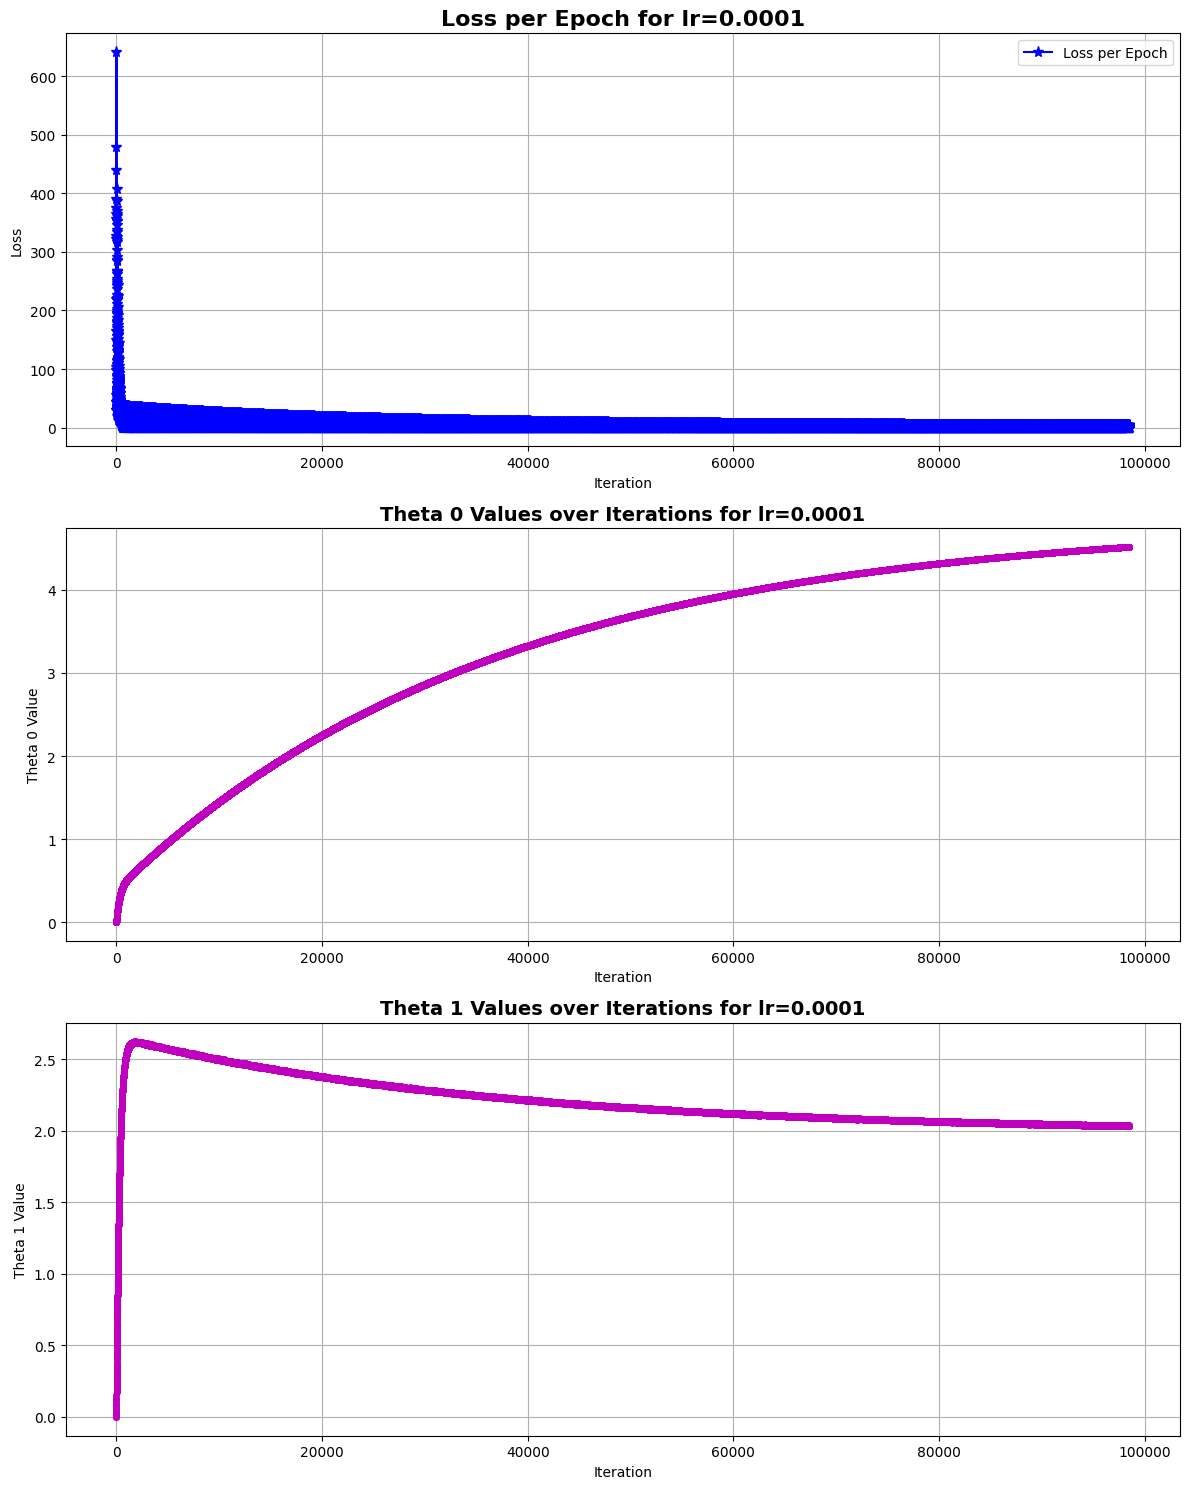

In [10]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)

### Use Large Learning Rate

In [11]:
lr = 0.01

# Run Stocastic GD
_, weights_history, cost_history, r2 = SGD_python(X, y, learning_rate=lr)

Epoch [20/10000] - Avg Loss: 1.228 - R2: 0.972 - Weights: [4.56406263 2.08950177]:   0%|                         | 20/500000 [00:00<23:42, 351.42it/s]

Loss increased for 5 consecutive epochs. Stopping training at epoch 21.
Time taken for SGD_python: 0.0599 seconds
                     Final Training Report
🟢 Total Epochs Run : 21
🟢 Final MSE        : 0.025
🟢 Final R-square   : 0.972
🟢 Final Weights    : [4.5832 1.9974]


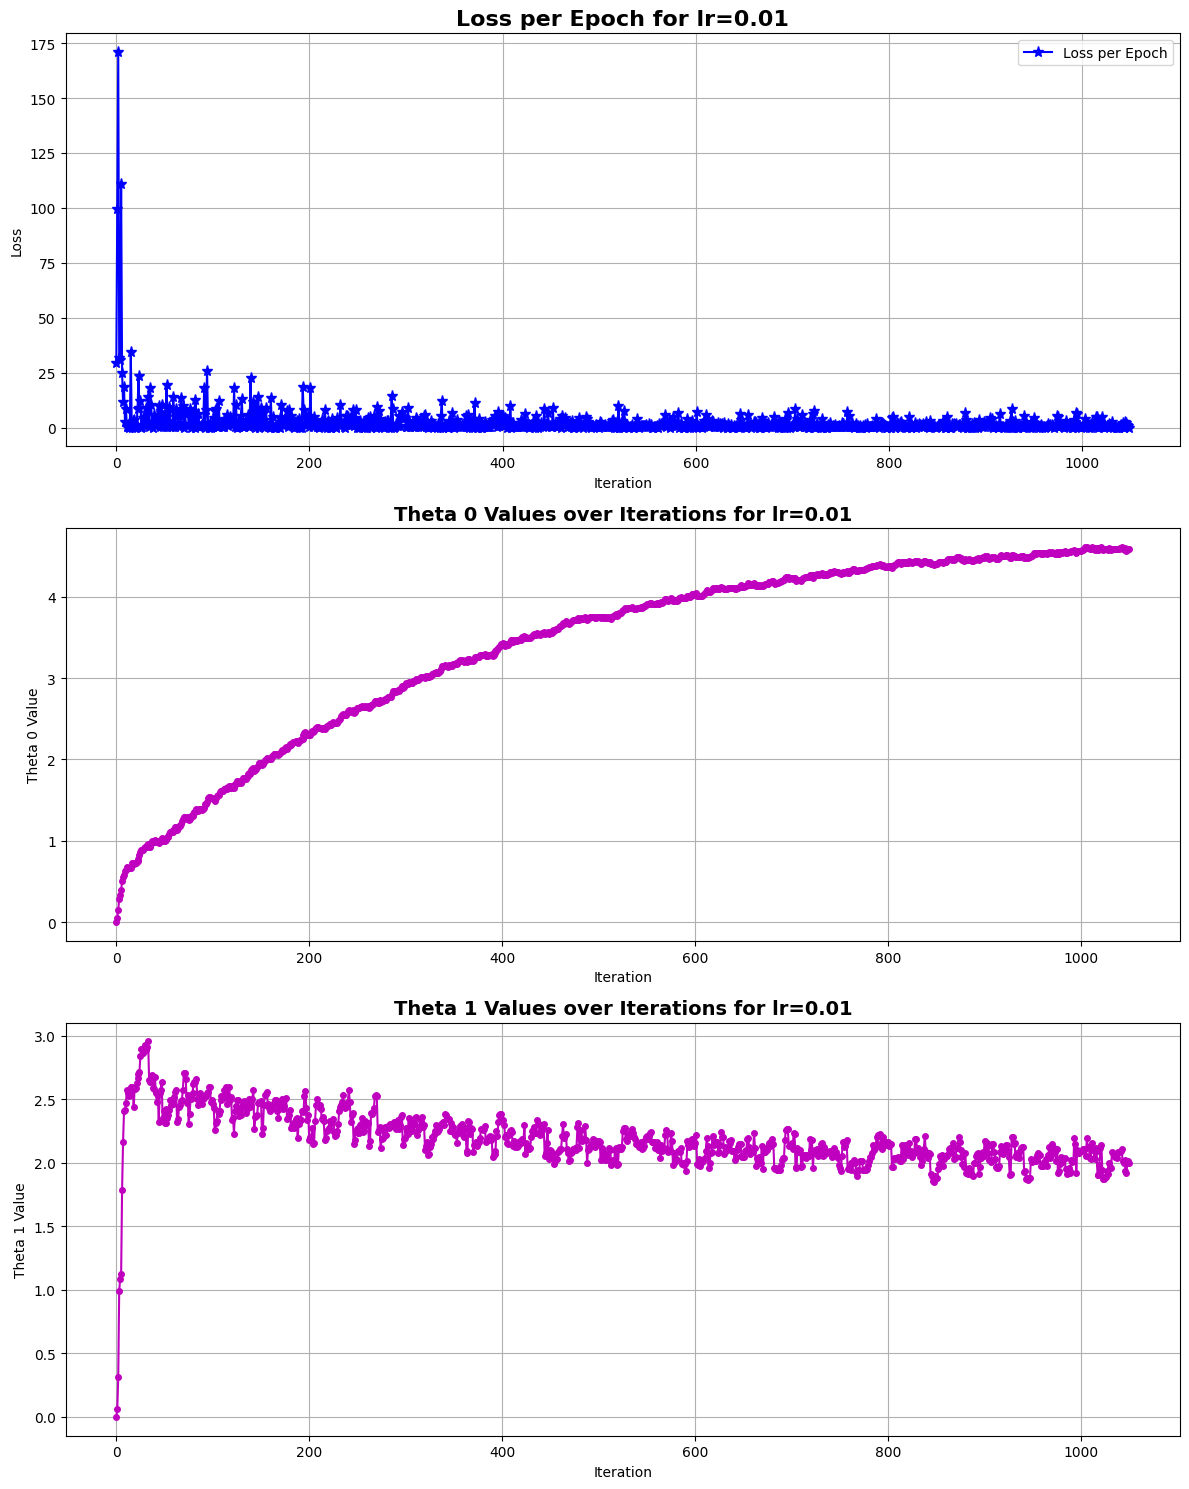

In [12]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)

## 3.Mini-Batch Gradient Descent Using PyTorch
The `Mini_BGD_python` function implements the Stocastic gradient descent algorithm using **PyTorch** to optimize the parameters (weights) of a linear regression model.

**Key Changes from the Python Code:**
1. **Data Conversion**: The input data `X` and `y` are converted to PyTorch tensors.
2. **Bias Term**: The bias term is added using `torch.cat` to create a column of ones.
3. **Gradient Calculation**: The gradient  is calculated using tensor operations, leveraging PyTorch's matrix multiplication.
4. **Loss Calculation**: Losses are appended as Python floats using `loss.item()`.
5. **Weights Update**: The weights are updated in place using standard tensor operations.

### Implementing Mini-BGD Using PyTorch

In [26]:
@report_decorator
@time_decorator
def SGD_pytorch(X, y, **hyperparams):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    batch_size = hyperparams.get('batch_size', 4)
    tolerance = hyperparams.get('tolerance', 0.001)

    X = np.insert(X, 0, 1, axis=1)
    m, n = X.shape                          # Number of instance and features of the dataset

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

    cost_history = []                   # Store all losses per iteration
    avg_losses = []                     # Store all average losses per epoch
    weights_history = []                # Store all weights per iteration
    patience_count = 0                  # Initialize a counter for early stopping
    best_loss = float('inf')            # Initialize best loss with infinity
    theta = torch.zeros((n, 1), dtype=torch.float32)  # Initialize theta with zeros
    weights_history.append(theta.clone())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs * m, colour='green', ncols=150, bar_format=pbar_format)
    
    for epoch in range(epochs):
        total_loss = 0  # Total loss for the epoch
        indices = np.random.permutation(m)  # Shuffle the dataset
        X_shuffled = X_tensor[indices]
        y_shuffled = y_tensor[indices]
        
        for i in range(m):
            # Predict output using current theta (weights)
            x_i, y_i = X_shuffled[i, :].reshape(1, -1), y_shuffled[i]
            h_x = (x_i @ theta).item()

            # Calculate error and loss
            e = h_x - y_i.item()  # Convert y_i tensor to a Python float
            loss = e**2
            cost_history.append(loss)  # Append loss
            total_loss += loss

            # Calculate gradient and update weights
            gradient = x_i.T * e  # Ensure gradient is correctly shaped
            theta = theta - learning_rate * gradient
            
            weights_history.append(theta.clone())  # Store updated weights

        # Average loss for the epoch
        avg_loss = total_loss / m
        avg_losses.append(avg_loss)

        # Track the best loss and early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_count = 0  # Reset patience if improved
        else:
            patience_count += 1

        if patience_count >= 5:  # Stop if no improvement for 5 consecutive epochs
            print(f"Loss increased for 5 consecutive epochs. Stopping training at epoch {epoch + 1}.")
            break

        # Compute R² (Ensure evaluate_model handles tensors or convert to NumPy)
        r2 = evaluate_model(X, y, theta.detach().numpy())

        # Print progress
        pbar.set_description(f"Epoch [{epoch + 1}/{epochs}] - Avg Loss: {avg_loss:.3f} - R2: {r2:.3f} - Weights: {theta.flatten().tolist()}")
        pbar.update(m)

    pbar.close()
    return epoch, weights_history, cost_history, r2


### Use Small Learning Rate

In [27]:
# Initialize hyperparameters
lr = 0.0001

# Run Stocastic GD
_, weights_history, cost_history, r2 = SGD_pytorch(X, y, learning_rate=lr)

Loss increased for 5 consecutive epochs. Stopping training at epoch 1970.
Time taken for SGD_pytorch: 26.4990 seconds
                     Final Training Report
🟢 Total Epochs Run : 1970
🟢 Final MSE        : 0.893
🟢 Final R-square   : 0.976
🟢 Final Weights    : [4.5186 2.0355]


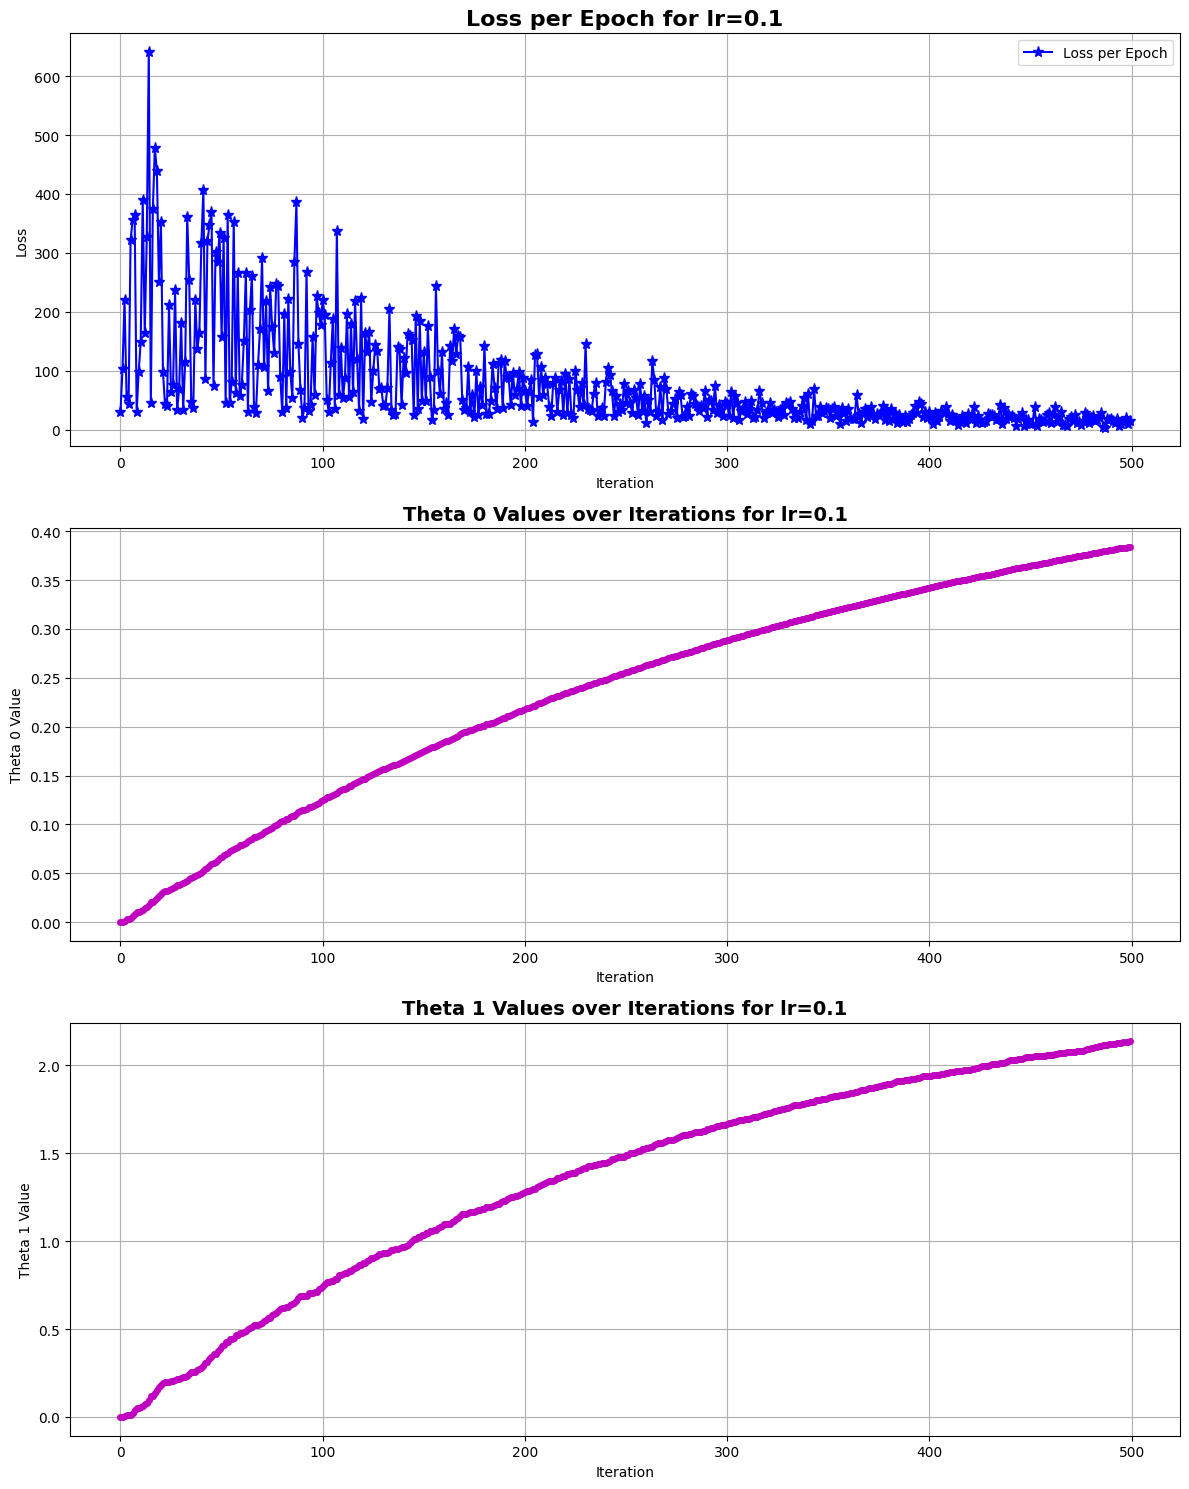

In [30]:
# Plot results
plot_results(weights_history[:500], cost_history[:500], lr=lr)

### Use Large Learning Rate

In [33]:
lr = 0.05

# Run Stocastic GD
_, weights_history, cost_history, r2 = SGD_pytorch(X, y, learning_rate=lr)

Epoch [5/10000] - Avg Loss: 345717.772 - R2: -4502.664 - Weights: [115.5521240234375, 55.68793487548828]:   0%| | 250/500000 [00:00<03:22, 2465.40it/s


Loss increased for 5 consecutive epochs. Stopping training at epoch 6.
Time taken for SGD_pytorch: 0.1102 seconds
                     Final Training Report
🟢 Total Epochs Run : 6
🟢 Final MSE        : 1334898.257
🟢 Final R-square   : -4502.664
🟢 Final Weights    : [3.2918 32.9822]


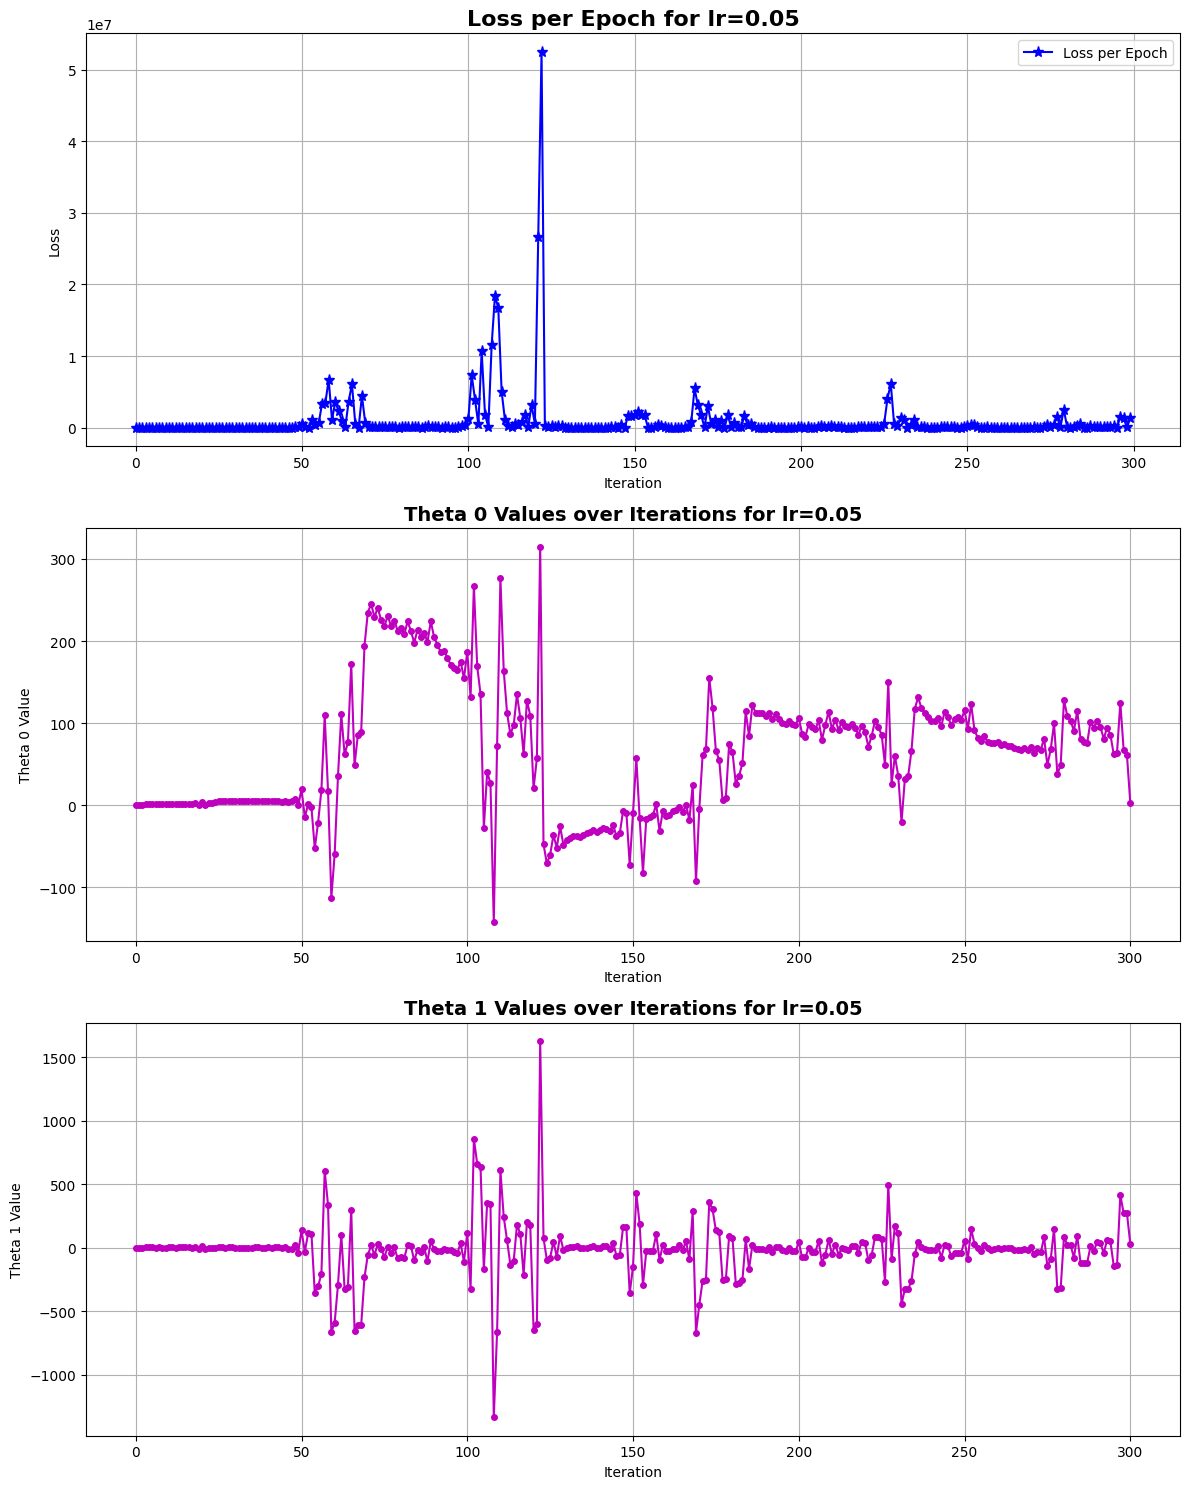

In [35]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)